# Audio Processing

## Import dependencies

In [1]:
import torch
import torchaudio
import torch.nn.functional as F
from torch.nn import init
import torch.nn as nn
from torchsummary import summary

In [2]:
import os
from matplotlib import pyplot as plt
import glob
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
import librosa
import random
from sklearn.metrics import precision_recall_curve, auc, f1_score, accuracy_score, confusion_matrix, roc_auc_score
from copy import deepcopy
import sounddevice as sd
from scipy.io.wavfile import write
import noisereduce as nr

/Users/chuamingfeng/Desktop/Synapxe/Swallow_Prediction/swallow/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
swallow_file = os.path.join('..', 'data', 'processed', '1.wav')
not_swallow_file = os.path.join('..', 'data', 'sound_datasets', 'urbansound8k', 'audio', 'fold1', '7061-6-0-0.wav')

In [4]:
def process_audio_file(file_path):
    # Load the audio file
    waveform, sample_rate = torchaudio.load(file_path)

    # Convert to mono if the audio is in stereo format
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0).unsqueeze(0)

    # Resample the audio to 16000
    resampler = torchaudio.transforms.Resample(sample_rate, 16000)
    waveform = resampler(waveform)

    return waveform


In [5]:
wave = process_audio_file(swallow_file)
nwave = process_audio_file(not_swallow_file)

## Visualisation functions

In [6]:
def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def plot_waveforms(waveform1, waveform2, sample_rate, title="Waveforms", xlim=None, ylim=None):
    waveform1 = waveform1.numpy()
    waveform2 = waveform2.numpy()

    num_channels1, num_frames1 = waveform1.shape
    num_channels2, num_frames2 = waveform2.shape

    time_axis1 = torch.arange(0, num_frames1) / sample_rate
    time_axis2 = torch.arange(0, num_frames2) / sample_rate

    assert num_channels1 == num_channels2, "Number of channels must match for plotting."

    figure, axes = plt.subplots(num_channels1, 1, sharex=True, sharey=True)
    if num_channels1 == 1:
        axes = [axes]

    for c in range(num_channels1):
        axes[c].plot(time_axis1, waveform1[c], label='Waveform 1', linewidth=1)
        axes[c].plot(time_axis2, waveform2[c], label='Waveform 2', linewidth=1)
        axes[c].grid(True)
        if num_channels1 > 1:
            axes[c].set_ylabel(f'Channel {c + 1}')
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
        axes[c].legend()

    figure.suptitle(title)
    plt.show(block=False)

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

## Visualise waveforms

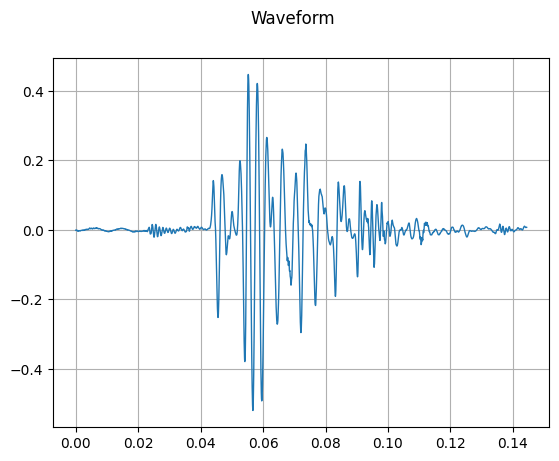

In [7]:
plot_waveform(wave, 16000)

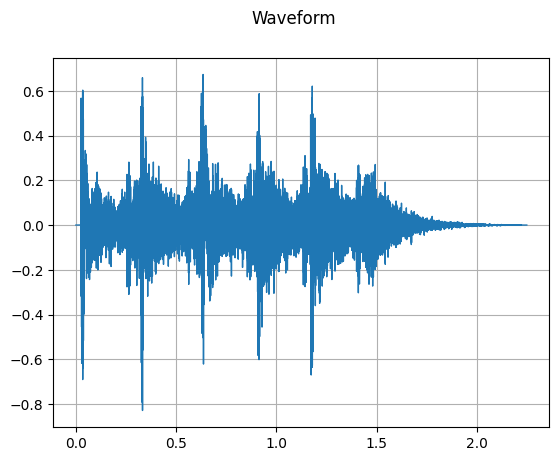

In [8]:
plot_waveform(nwave, 16000)

In [9]:
POS = os.path.join('..', 'data', 'processed')
pos = glob.iglob(POS + '/**/*.wav', recursive=True)


In [10]:
NEG = os.path.join('..', 'data', 'sound_datasets', 'urbansound8k', 'audio')
neg = glob.iglob(NEG + '/**/*.wav', recursive=True)

In [11]:
# Create a dataframe for positive samples
pos_df = pd.DataFrame({'file_path': list(pos), 'label': 1})

# Create a dataframe for negative samples
neg_df = pd.DataFrame({'file_path': list(neg), 'label': 0})

neg_df_downsampled = neg_df.sample(n=2*len(pos_df), random_state=42)

# Concatenate the dataframes
df = pd.concat([pos_df, neg_df_downsampled], ignore_index=True)


In [12]:
len(pos_df)

176

In [13]:
df

,file_path,label
0,../data/processed/16.wav,1
1,../data/processed/103.wav,1
2,../data/processed/117.wav,1
3,../data/processed/116.wav,1
4,../data/processed/102.wav,1
...,...,...
523,../data/sound_datasets/urbansound8k/audio/fold...,0
524,../data/sound_datasets/urbansound8k/audio/fold...,0
525,../data/sound_datasets/urbansound8k/audio/fold...,0
526,../data/sound_datasets/urbansound8k/audio/fold...,0


## Dataset stats

In [14]:
lengths = []
for file in os.listdir(POS):
    if file.endswith('.wav'):
        tensor_wave = process_audio_file(os.path.join(POS, file))
        lengths.append(len(tensor_wave[0]))

In [15]:
print(f'Min: {np.min(lengths)} \n Max: {np.max(lengths)} \n Mean: {np.mean(lengths)}')

Min: 1791 
 Max: 13019 
 Mean: 5133.619318181818


we standardize the number of values to 80000 tentatively (equivalent to 5s of audio)

## Training baseline model

In [16]:
def pad_trunc(wav, limit=16000):
    num_rows, sig_len = wav.shape

    if (sig_len > limit):
        # Truncate the signal to the given length
        wav = wav[:,:limit]

    elif (sig_len < limit):
        # Length of padding to add at the beginning and end of the signal
        pad_begin_len = random.randint(0, limit - sig_len)
        pad_end_len = limit - sig_len - pad_begin_len

        # Pad with 0s
        pad_begin = torch.zeros((num_rows, pad_begin_len))
        pad_end = torch.zeros((num_rows, pad_end_len))

        wav = torch.cat((pad_begin, wav, pad_end), 1)
        
    return wav

In [17]:
# Convert the dataset to a PyTorch dataset
class AudioDataset(Dataset):
    def __init__(self, dataset, augment=False):
        self.data = dataset
        self.augment = augment
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        file_path, label = self.data.iloc[index]
        
        waveform = process_audio_file(file_path)
        waveform = pad_trunc(waveform, 80000)
        
        if self.augment and label == 1:
            waveform = torchaudio.transforms.PitchShift(16000, 4)(waveform)
            waveform = waveform.detach()
            waveform = self.add_noise(waveform, 0.05).to(torch.float32)

        spectrogram = torchaudio.transforms.MelSpectrogram(n_fft=16000)(waveform)
        spectrogram = torchaudio.transforms.AmplitudeToDB(stype="amplitude", top_db=80)(spectrogram)

        return spectrogram, label
    
    def add_noise(self, data, alpha):
        noise = np.random.randn(len(data))
        data_noise = data + alpha*noise
        return data_noise

In [18]:
waveform = process_audio_file(swallow_file)
waveform = pad_trunc(waveform, 80000)
spectrogram = torchaudio.transforms.MelSpectrogram(n_fft=16000)(waveform)
spectrogram = torchaudio.transforms.AmplitudeToDB(stype="amplitude", top_db=80)(spectrogram)

Shape: (1, 128, 11)
Dtype: torch.float32
 - Max:     84.870
 - Min:      4.870
 - Mean:     7.277
 - Std Dev: 10.391

tensor([[[4.8701, 4.8701, 4.8701,  ..., 4.8701, 4.8701, 4.8701],
         [4.8701, 4.8701, 4.8701,  ..., 4.8701, 4.8701, 4.8701],
         [4.8701, 4.8701, 4.8701,  ..., 4.8701, 4.8701, 4.8701],
         ...,
         [4.8701, 4.8701, 4.8701,  ..., 4.8701, 4.8701, 4.8701],
         [4.8701, 4.8701, 4.8701,  ..., 4.8701, 4.8701, 4.8701],
         [4.8701, 4.8701, 4.8701,  ..., 4.8701, 4.8701, 4.8701]]])



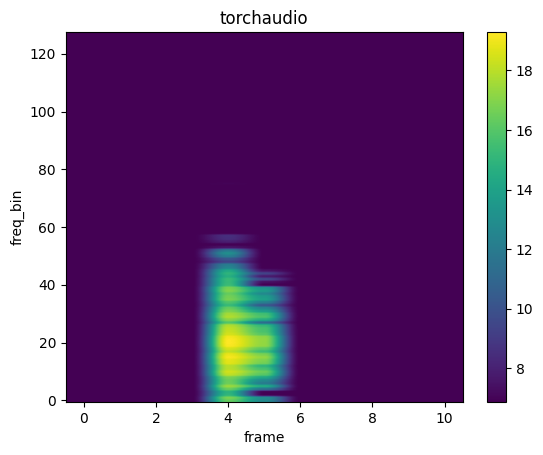

In [19]:
print_stats(spectrogram)
plot_spectrogram(spectrogram[0], title='torchaudio')

In [20]:
nwaveform = process_audio_file(not_swallow_file)
nwaveform = pad_trunc(nwaveform, 80000)
nspectrogram = torchaudio.transforms.MelSpectrogram(n_fft=16000)(nwaveform)
nspectrogram = torchaudio.transforms.AmplitudeToDB(stype="amplitude", top_db=80)(nspectrogram)

Shape: (1, 128, 11)
Dtype: torch.float32
 - Max:     91.607
 - Min:     11.607
 - Mean:    30.445
 - Std Dev: 24.224

tensor([[[11.6069, 46.9591, 78.2959,  ..., 11.6069, 11.6069, 11.6069],
         [11.6069, 50.1795, 79.3128,  ..., 11.6069, 11.6069, 11.6069],
         [11.6069, 41.6352, 69.7175,  ..., 11.6069, 11.6069, 11.6069],
         ...,
         [11.6069, 24.3753, 60.6751,  ..., 11.6069, 11.6069, 11.6069],
         [11.6069, 31.4063, 64.4608,  ..., 11.6069, 11.6069, 11.6069],
         [11.6069, 25.9219, 66.0305,  ..., 11.6069, 11.6069, 11.6069]]])



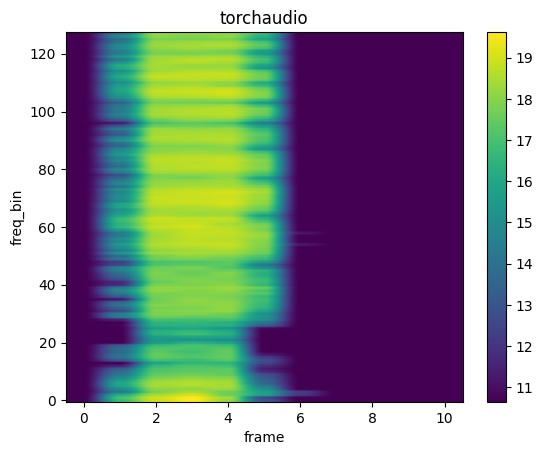

In [21]:
print_stats(nspectrogram)
plot_spectrogram(nspectrogram[0], title='torchaudio')

/Users/chuamingfeng/Desktop/Synapxe/Swallow_Prediction/swallow/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


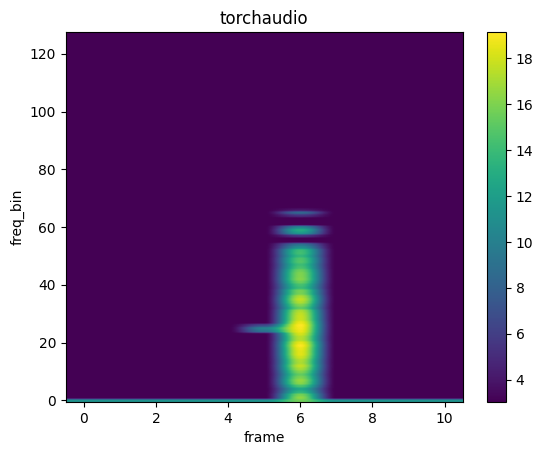

In [22]:
def add_noise(data, alpha):
    noise = np.random.randn(len(data))
    data_noise = data + alpha*noise
    return data_noise
augwaveform = process_audio_file(swallow_file)
augwaveform = pad_trunc(augwaveform, 80000)
augwaveform = torchaudio.transforms.PitchShift(16000, 4)(augwaveform)
augwaveform = augwaveform.detach()
augwaveform = add_noise(augwaveform, 0.05).to(torch.float32)
augspectrogram = torchaudio.transforms.MelSpectrogram(n_fft=16000)(augwaveform)
augspectrogram = torchaudio.transforms.AmplitudeToDB(stype="amplitude", top_db=80)(augspectrogram)
plot_spectrogram(augspectrogram[0], title='torchaudio')

In [24]:
ori_dataset = AudioDataset(df)
aug_dataset = AudioDataset(pos_df, True)
train_size = int(0.8 * len(ori_dataset))
val_size = int(0.1 * len(ori_dataset))
test_size = len(ori_dataset) - train_size - val_size

In [25]:
generator = torch.Generator().manual_seed(2024)
train_set, val_set, test_set = random_split(ori_dataset, [train_size, val_size, test_size], generator=generator)
combined_train_set = ConcatDataset([train_set, aug_dataset])

In [26]:
batch_size = 16
num_cpus = os.cpu_count()

# DataLoader for training set
train_loader = DataLoader(combined_train_set, batch_size=batch_size, shuffle=True)

# DataLoader for validation set
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# DataLoader for test set
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [23]:
class SwallowClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Second Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Second Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=1)
        self.sigmoid = nn.Sigmoid()

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)
        x = self.sigmoid(x)

        # Final output
        return x

In [24]:
summary(SwallowClassifier(), (1, 128, 11))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 8, 64, 6]             208
            Conv2d-2             [-1, 8, 64, 6]             208
              ReLU-3             [-1, 8, 64, 6]               0
              ReLU-4             [-1, 8, 64, 6]               0
       BatchNorm2d-5             [-1, 8, 64, 6]              16
       BatchNorm2d-6             [-1, 8, 64, 6]              16
            Conv2d-7            [-1, 16, 32, 3]           1,168
            Conv2d-8            [-1, 16, 32, 3]           1,168
              ReLU-9            [-1, 16, 32, 3]               0
             ReLU-10            [-1, 16, 32, 3]               0
      BatchNorm2d-11            [-1, 16, 32, 3]              32
      BatchNorm2d-12            [-1, 16, 32, 3]              32
           Conv2d-13            [-1, 32, 16, 2]           4,640
           Conv2d-14            [-1, 32

In [25]:
def calculate_metrics(labels, preds, probas_pred):
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    
    precision, recall, _ = precision_recall_curve(labels, probas_pred)
    pr_auc = auc(recall, precision)
    roc_auc = roc_auc_score(labels, probas_pred)
    
    return accuracy, f1, pr_auc, roc_auc

In [26]:
def evaluate(model, val_dl, criterion, threshold, device):
    model.eval()
    all_labels = []
    all_preds = []
    all_proba_preds = []
    total_loss = 0.0

    with torch.no_grad():
        for data in val_dl:
            inputs, labels = data[0].to(device), data[1].to(device)

            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            probas_pred = model(inputs)
            labels = labels.view(-1, 1).float()
            loss = criterion(probas_pred, labels)
            total_loss += loss.item()

            pred = (probas_pred >= threshold).float()

            all_labels.extend(labels.cpu().numpy().astype(int).squeeze())
            all_preds.extend(pred.cpu().numpy().astype(int).squeeze())
            all_proba_preds.extend(probas_pred.cpu().numpy().astype(float).squeeze())

    avg_loss = total_loss / len(val_dl)
    return avg_loss, all_labels, all_preds, all_proba_preds

In [27]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0.01):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.best_model_state_dict = None
        self.best_epoch = 0

    def __call__(self, val_loss, model, epoch):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_state_dict = deepcopy(model.state_dict())
            self.best_epoch = epoch
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def restore_best_model(self, model):
        model.load_state_dict(self.best_model_state_dict)
        print("Restored best model parameters.")

In [28]:
def train(model, train_dl, val_dl, num_epochs, threshold, patience, device):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                    steps_per_epoch=int(len(train_dl)),
                                                    epochs=num_epochs,
                                                    anneal_strategy='linear')

    train_losses = []
    val_losses = []

    early_stopping = EarlyStopping(patience=patience)
    best_epoch = 0

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0

        # Training phase
        model.train()
        for i, data in enumerate(train_dl):
            inputs, labels = data[0].to(device), data[1].to(device)

            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            optimizer.zero_grad()
            probas_pred = model(inputs)
            labels = labels.view(-1, 1).float()
            loss = criterion(probas_pred, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item()

            pred = (probas_pred >= threshold).float()
            correct_prediction += (pred == labels).sum().item()
            total_prediction += pred.shape[0]

        avg_loss = running_loss / len(train_dl)
        train_accuracy = correct_prediction / total_prediction

        # Validation phase
        val_loss, val_labels, val_preds, val_proba_preds = evaluate(model, val_dl, criterion, threshold, device)

        # Check for early stopping
        early_stopping(val_loss, model, epoch)

        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch}")
            print(f"Best model at epoch {early_stopping.best_epoch} used")
            break

        # Calculate metrics
        val_accuracy, val_f1, val_pr_auc, val_roc_auc = calculate_metrics(val_labels, val_preds, val_proba_preds)

        # Calculate confusion matrix
        val_conf_matrix = confusion_matrix(val_labels, val_preds)

        train_losses.append(avg_loss)
        val_losses.append(val_loss)

        print(f'Epoch: {epoch}, Train Loss: {avg_loss:.2f}, Train Accuracy: {train_accuracy:.2f}, '
              f'Val Loss: {val_loss:.2f}, Val Accuracy: {val_accuracy:.2f}, F1: {val_f1:.2f}, PR-AUC: {val_pr_auc:.2f}, ROC-AUC: {val_roc_auc:.2f}')

        print('Validation Confusion Matrix:')
        print(val_conf_matrix)

    early_stopping.restore_best_model(model)

    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()

    print('Finished Training')


In [33]:
model = SwallowClassifier()

/Users/chuamingfeng/Desktop/Synapxe/Swallow_Prediction/swallow/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 0, Train Loss: 0.68, Train Accuracy: 0.53, Val Loss: 0.68, Val Accuracy: 0.83, F1: 0.84, PR-AUC: 0.70, ROC-AUC: 0.90
Validation Confusion Matrix:
[[32  8]
 [ 1 11]]


/Users/chuamingfeng/Desktop/Synapxe/Swallow_Prediction/swallow/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 1, Train Loss: 0.51, Train Accuracy: 0.82, Val Loss: 0.65, Val Accuracy: 0.83, F1: 0.84, PR-AUC: 0.62, ROC-AUC: 0.91
Validation Confusion Matrix:
[[31  9]
 [ 0 12]]


/Users/chuamingfeng/Desktop/Synapxe/Swallow_Prediction/swallow/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 2, Train Loss: 0.40, Train Accuracy: 0.86, Val Loss: 0.45, Val Accuracy: 0.83, F1: 0.84, PR-AUC: 0.92, ROC-AUC: 0.98
Validation Confusion Matrix:
[[31  9]
 [ 0 12]]


/Users/chuamingfeng/Desktop/Synapxe/Swallow_Prediction/swallow/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 3, Train Loss: 0.31, Train Accuracy: 0.89, Val Loss: 0.55, Val Accuracy: 0.83, F1: 0.84, PR-AUC: 0.86, ROC-AUC: 0.96
Validation Confusion Matrix:
[[31  9]
 [ 0 12]]


/Users/chuamingfeng/Desktop/Synapxe/Swallow_Prediction/swallow/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 4, Train Loss: 0.25, Train Accuracy: 0.92, Val Loss: 0.48, Val Accuracy: 0.83, F1: 0.84, PR-AUC: 0.95, ROC-AUC: 0.98
Validation Confusion Matrix:
[[31  9]
 [ 0 12]]


/Users/chuamingfeng/Desktop/Synapxe/Swallow_Prediction/swallow/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 5, Train Loss: 0.20, Train Accuracy: 0.94, Val Loss: 0.50, Val Accuracy: 0.83, F1: 0.84, PR-AUC: 0.95, ROC-AUC: 0.98
Validation Confusion Matrix:
[[31  9]
 [ 0 12]]


/Users/chuamingfeng/Desktop/Synapxe/Swallow_Prediction/swallow/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 6, Train Loss: 0.19, Train Accuracy: 0.93, Val Loss: 0.38, Val Accuracy: 0.87, F1: 0.87, PR-AUC: 0.99, ROC-AUC: 1.00
Validation Confusion Matrix:
[[33  7]
 [ 0 12]]


/Users/chuamingfeng/Desktop/Synapxe/Swallow_Prediction/swallow/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 7, Train Loss: 0.16, Train Accuracy: 0.95, Val Loss: 0.40, Val Accuracy: 0.85, F1: 0.86, PR-AUC: 0.97, ROC-AUC: 0.99
Validation Confusion Matrix:
[[32  8]
 [ 0 12]]


/Users/chuamingfeng/Desktop/Synapxe/Swallow_Prediction/swallow/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 8, Train Loss: 0.17, Train Accuracy: 0.94, Val Loss: 0.33, Val Accuracy: 0.88, F1: 0.89, PR-AUC: 0.98, ROC-AUC: 0.99
Validation Confusion Matrix:
[[34  6]
 [ 0 12]]


/Users/chuamingfeng/Desktop/Synapxe/Swallow_Prediction/swallow/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 9, Train Loss: 0.16, Train Accuracy: 0.94, Val Loss: 0.31, Val Accuracy: 0.90, F1: 0.91, PR-AUC: 1.00, ROC-AUC: 1.00
Validation Confusion Matrix:
[[35  5]
 [ 0 12]]


/Users/chuamingfeng/Desktop/Synapxe/Swallow_Prediction/swallow/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 10, Train Loss: 0.15, Train Accuracy: 0.95, Val Loss: 0.28, Val Accuracy: 0.90, F1: 0.91, PR-AUC: 0.99, ROC-AUC: 1.00
Validation Confusion Matrix:
[[35  5]
 [ 0 12]]


/Users/chuamingfeng/Desktop/Synapxe/Swallow_Prediction/swallow/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 11, Train Loss: 0.14, Train Accuracy: 0.96, Val Loss: 0.20, Val Accuracy: 0.94, F1: 0.94, PR-AUC: 1.00, ROC-AUC: 1.00
Validation Confusion Matrix:
[[37  3]
 [ 0 12]]


/Users/chuamingfeng/Desktop/Synapxe/Swallow_Prediction/swallow/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 12, Train Loss: 0.13, Train Accuracy: 0.95, Val Loss: 0.18, Val Accuracy: 0.92, F1: 0.93, PR-AUC: 1.00, ROC-AUC: 1.00
Validation Confusion Matrix:
[[36  4]
 [ 0 12]]


/Users/chuamingfeng/Desktop/Synapxe/Swallow_Prediction/swallow/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 13, Train Loss: 0.12, Train Accuracy: 0.97, Val Loss: 0.16, Val Accuracy: 0.94, F1: 0.94, PR-AUC: 1.00, ROC-AUC: 1.00
Validation Confusion Matrix:
[[37  3]
 [ 0 12]]


/Users/chuamingfeng/Desktop/Synapxe/Swallow_Prediction/swallow/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 14, Train Loss: 0.14, Train Accuracy: 0.95, Val Loss: 0.23, Val Accuracy: 0.90, F1: 0.91, PR-AUC: 1.00, ROC-AUC: 1.00
Validation Confusion Matrix:
[[35  5]
 [ 0 12]]


/Users/chuamingfeng/Desktop/Synapxe/Swallow_Prediction/swallow/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 15, Train Loss: 0.11, Train Accuracy: 0.97, Val Loss: 0.17, Val Accuracy: 0.92, F1: 0.93, PR-AUC: 1.00, ROC-AUC: 1.00
Validation Confusion Matrix:
[[36  4]
 [ 0 12]]


/Users/chuamingfeng/Desktop/Synapxe/Swallow_Prediction/swallow/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 16, Train Loss: 0.11, Train Accuracy: 0.96, Val Loss: 0.17, Val Accuracy: 0.92, F1: 0.93, PR-AUC: 1.00, ROC-AUC: 1.00
Validation Confusion Matrix:
[[36  4]
 [ 0 12]]


/Users/chuamingfeng/Desktop/Synapxe/Swallow_Prediction/swallow/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 17, Train Loss: 0.10, Train Accuracy: 0.96, Val Loss: 0.14, Val Accuracy: 0.94, F1: 0.94, PR-AUC: 1.00, ROC-AUC: 1.00
Validation Confusion Matrix:
[[37  3]
 [ 0 12]]


/Users/chuamingfeng/Desktop/Synapxe/Swallow_Prediction/swallow/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 18, Train Loss: 0.12, Train Accuracy: 0.97, Val Loss: 0.17, Val Accuracy: 0.94, F1: 0.94, PR-AUC: 1.00, ROC-AUC: 1.00
Validation Confusion Matrix:
[[37  3]
 [ 0 12]]


/Users/chuamingfeng/Desktop/Synapxe/Swallow_Prediction/swallow/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 19, Train Loss: 0.11, Train Accuracy: 0.97, Val Loss: 0.13, Val Accuracy: 0.92, F1: 0.93, PR-AUC: 1.00, ROC-AUC: 1.00
Validation Confusion Matrix:
[[36  4]
 [ 0 12]]


/Users/chuamingfeng/Desktop/Synapxe/Swallow_Prediction/swallow/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 20, Train Loss: 0.10, Train Accuracy: 0.97, Val Loss: 0.11, Val Accuracy: 0.94, F1: 0.94, PR-AUC: 1.00, ROC-AUC: 1.00
Validation Confusion Matrix:
[[37  3]
 [ 0 12]]


/Users/chuamingfeng/Desktop/Synapxe/Swallow_Prediction/swallow/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 21, Train Loss: 0.10, Train Accuracy: 0.96, Val Loss: 0.08, Val Accuracy: 0.98, F1: 0.98, PR-AUC: 1.00, ROC-AUC: 1.00
Validation Confusion Matrix:
[[39  1]
 [ 0 12]]


/Users/chuamingfeng/Desktop/Synapxe/Swallow_Prediction/swallow/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 22, Train Loss: 0.09, Train Accuracy: 0.98, Val Loss: 0.13, Val Accuracy: 0.96, F1: 0.96, PR-AUC: 1.00, ROC-AUC: 1.00
Validation Confusion Matrix:
[[38  2]
 [ 0 12]]


/Users/chuamingfeng/Desktop/Synapxe/Swallow_Prediction/swallow/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 23, Train Loss: 0.09, Train Accuracy: 0.97, Val Loss: 0.09, Val Accuracy: 0.98, F1: 0.98, PR-AUC: 1.00, ROC-AUC: 1.00
Validation Confusion Matrix:
[[39  1]
 [ 0 12]]


/Users/chuamingfeng/Desktop/Synapxe/Swallow_Prediction/swallow/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 24, Train Loss: 0.09, Train Accuracy: 0.97, Val Loss: 0.08, Val Accuracy: 0.98, F1: 0.98, PR-AUC: 0.99, ROC-AUC: 1.00
Validation Confusion Matrix:
[[39  1]
 [ 0 12]]


/Users/chuamingfeng/Desktop/Synapxe/Swallow_Prediction/swallow/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 25, Train Loss: 0.11, Train Accuracy: 0.96, Val Loss: 0.14, Val Accuracy: 0.92, F1: 0.93, PR-AUC: 0.98, ROC-AUC: 0.99
Validation Confusion Matrix:
[[36  4]
 [ 0 12]]


/Users/chuamingfeng/Desktop/Synapxe/Swallow_Prediction/swallow/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Early stopping at epoch 26
Best model at epoch 21 used
Restored best model parameters.


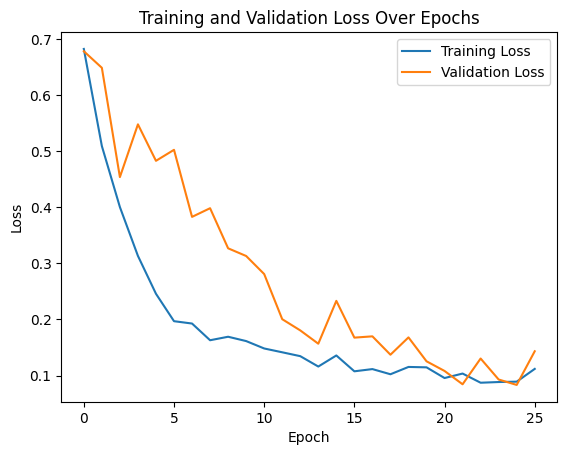

Finished Training


In [34]:
num_epochs=100
threshold = 0.5
patience = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train(model, train_loader, val_loader, num_epochs, threshold, patience, device)

In [29]:
def inference(model, val_dl, threshold, device):
  correct_prediction = 0
  total_prediction = 0
  model.eval()
  all_labels = []
  all_preds = []
  all_proba_preds = []

  # Disable gradient updates
  with torch.no_grad():
    for data in val_dl:
      # Get the input features and target labels, and put them on the GPU
      inputs, labels = data[0].to(device), data[1].to(device)

      # Normalize the inputs
      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s

      probas_pred = model(inputs)
      labels = labels.view(-1, 1).float()

      pred = (probas_pred >= threshold).float()

      # Count of predictions that matched the target label
      correct_prediction += (pred == labels).sum().item()
      total_prediction += pred.shape[0]
      #print(f"probas: {probas_pred}, labels: {labels}, pred: {pred}, correct: {correct_prediction}, total: {total_prediction}")
      all_labels.extend(labels.cpu().numpy().astype(int).squeeze())
      all_preds.extend(pred.cpu().numpy().astype(int).squeeze())
      all_proba_preds.extend(probas_pred.cpu().numpy().astype(float).squeeze())
    
    test_accuracy, test_f1, test_pr_auc, test_roc_auc = calculate_metrics(all_labels, all_preds, all_proba_preds)
    test_conf_matrix = confusion_matrix(all_labels, all_preds)
    print('Test Confusion Matrix:')
    print(test_conf_matrix)
  
  acc = correct_prediction/total_prediction
  print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}, Test Accuracy: {test_accuracy:.2f}, F1: {test_f1:.2f}, PR-AUC: {test_pr_auc:.2f}, ROC-AUC: {test_roc_auc:.2f}')

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inference(model, test_loader, 0.5, device)

Test Confusion Matrix:
[[31  1]
 [ 0 22]]
Accuracy: 0.98, Total items: 54, Test Accuracy: 0.98, F1: 0.98, PR-AUC: 1.00, ROC-AUC: 1.00


Test Confusion Matrix:
[[30  2]
 [ 2 37]]
Accuracy: 0.94, Total items: 71, Test Accuracy: 0.94, F1: 0.94, PR-AUC: 0.99, ROC-AUC: 0.99

In [38]:
torch.save(model.state_dict(), os.path.join(os.getcwd(), '..', 'models', '4.pt'))

## Testing on recordings

In [30]:
sd.query_devices()

  0 Ming Feng’s iPhone Microphone, Core Audio (1 in, 0 out)
> 1 External Microphone, Core Audio (1 in, 0 out)
< 2 External Headphones, Core Audio (0 in, 2 out)
  3 MacBook Pro Microphone, Core Audio (1 in, 0 out)
  4 MacBook Pro Speakers, Core Audio (0 in, 2 out)
  5 Microsoft Teams Audio, Core Audio (2 in, 2 out)
  6 ZoomAudioDevice, Core Audio (2 in, 2 out)

In [14]:
sd.default.device = [4, 3]

In [82]:
model = SwallowClassifier()
model.load_state_dict(torch.load(os.path.join('..', 'models', '4.pt')))

<All keys matched successfully>

In [32]:
def record_audio(duration=5, sample_rate=16000, channels=1):
    # Record audio for the specified duration
    print(f"Recording audio for {duration} seconds...")
    audio_data = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=channels, dtype='float32')
    sd.wait()
    print("Playing original recorded audio")
    sd.play(audio_data, sample_rate)
    """
    denoised_audio = nr.reduce_noise(y=audio_data, sr=sample_rate)
    print("Playing denoised recorded audio")
    sd.play(denoised_audio, sample_rate)
    """
    print("Recording complete.")
    return torch.tensor(np.expand_dims(audio_data.flatten(), axis=0))
    #return torch.tensor(np.expand_dims(audio_data.flatten(), axis=0)), torch.tensor(np.expand_dims(denoised_audio.flatten(), axis=0))


In [96]:
ori = record_audio()

Recording audio for 5 seconds...
Playing original recorded audio
Recording complete.


In [35]:
def process(waveform):
    waveform = pad_trunc(waveform, 80000)
    spectrogram = torchaudio.transforms.MelSpectrogram(n_fft=16000)(waveform)
    spectrogram = torchaudio.transforms.AmplitudeToDB(stype="amplitude", top_db=80)(spectrogram)
    return spectrogram

Shape: (1, 128, 11)
Dtype: torch.float32
 - Max:     92.643
 - Min:     12.643
 - Mean:    15.044
 - Std Dev:  6.504

tensor([[[92.6430, 12.6430, 12.6430,  ..., 12.6430, 12.6430, 12.6430],
         [76.9951, 18.4342, 12.6430,  ..., 19.1337, 14.3844, 18.6417],
         [77.0709, 39.8429, 40.7385,  ..., 34.4418, 35.5173, 43.1235],
         ...,
         [12.6430, 12.6430, 12.6430,  ..., 12.6430, 12.6430, 12.6430],
         [12.6430, 12.6430, 12.6430,  ..., 12.6430, 12.6430, 12.6430],
         [12.6430, 12.6430, 12.6430,  ..., 12.6430, 12.6430, 12.6430]]])



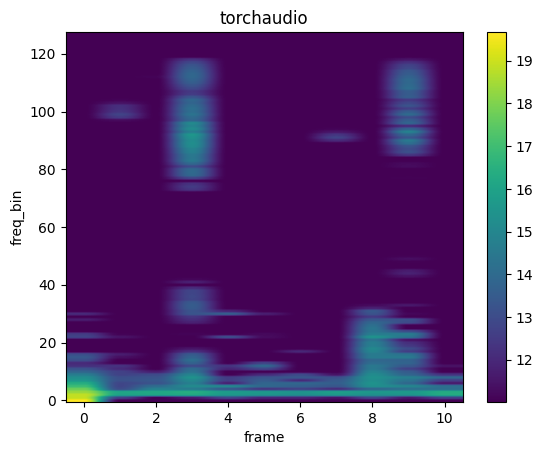

In [97]:
spectrogram = process(ori)
print_stats(spectrogram)
plot_spectrogram(spectrogram[0], title='torchaudio')

In [94]:
def predict(model, spectrogram):
    model.eval()
    spectrogram = spectrogram.unsqueeze(dim=0)
    spectrogram_m, spectrogram_s = spectrogram.mean(), spectrogram.std()
    spectrogram = (spectrogram - spectrogram_m) / spectrogram_s
    with torch.no_grad():
        pred = model(spectrogram)
    return pred

In [98]:
predict(model, spectrogram)

tensor([[0.6120]])